In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

#### Flow Like Water

In [3]:
with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    frontier_sample_data = pickle.load(file)
the_frontier_eddies = list(frontier_sample_data.keys())
# Depths will be limited to COW depths
d_df = pd.DataFrame(columns=['T' + str(t) for t in range(30)])
for eddy in the_frontier_eddies:
    row = []
    for t in range(30):
        df = frontier_sample_data[eddy]['T' + str(t)]['COW']['x']
        row.append(df.isna().idxmax() if df.isna().any() else len(df))
    d_df.loc[eddy] = row

eddy = the_frontier_eddies[2]

sub_data = {}

for t in range(30):
    
    method = 'VG'
    sub_data['T'+str(t)] = {}
    
    df = frontier_sample_data[eddy]['T'+str(t)][method].iloc[:d_df.loc[eddy]['T'+str(t)]]
    df = df.drop('TD', axis=1)
    
    # Interpolate to Density intervals
    rho = frontier_sample_data[eddy]['T'+str(t)]['rho']
    X, Y = np.meshgrid(frontier_sample_data[eddy]['T'+str(t)]['x'],
                       frontier_sample_data[eddy]['T'+str(t)]['y'])
    points = np.column_stack((X.ravel(), Y.ravel()))
    rhoc = []
    for k, (xc, yc) in enumerate(zip(df['x'], df['y'])):
        values = rho[:, :, k].ravel()
        target_point = np.array([[xc, yc]])
        rhoc.append(griddata(points, values, target_point, method='linear')[0])
    RHO_INT = 0.05
    new_rho = np.arange(np.floor(np.nanmin(rhoc) / RHO_INT) * RHO_INT,
                        np.ceil(np.nanmax(rhoc) / RHO_INT) * RHO_INT + RHO_INT,
                        RHO_INT)
    rho_data = pd.DataFrame({
        'x': np.interp(new_rho, rhoc, df['x']),
        'y': np.interp(new_rho, rhoc, df['y']),
        'Depth': np.interp(new_rho, rhoc, df['Depth']),
        'rho': new_rho
    })
    # TD_DENSITY = 26
    # x0 = rho_data.loc[np.isclose(rho_data['rho'], TD_DENSITY)].iloc[0]['x']
    # y0 = rho_data.loc[np.isclose(rho_data['rho'], TD_DENSITY)].iloc[0]['y']
    x0 = rho_data.iloc[0]['x']
    y0 = rho_data.iloc[0]['y']
    rho_data['x'] = rho_data['x'] - x0
    rho_data['y'] = rho_data['y'] - y0
    rho_data['TD'] = np.hypot(rho_data['x'], rho_data['y'])
    
    # Interpolate to Depth intervals
    DEPTH_INT = 10
    new_depth = np.arange(0, -np.floor(df['Depth'].min()/DEPTH_INT) * DEPTH_INT + DEPTH_INT, DEPTH_INT)
    depth_data = pd.DataFrame({
        'x': np.interp(new_depth, -df['Depth'], df['x']),
        'y': np.interp(new_depth, -df['Depth'], df['y']),
        'Depth': -new_depth,
        'rho': np.interp(new_depth, -df['Depth'], rhoc),
    })
    # TD_DEPTH = -150
    # x0 = depth_data.loc[np.isclose(depth_data['Depth'], TD_DEPTH)].iloc[0]['x']
    # y0 = depth_data.loc[np.isclose(depth_data['Depth'], TD_DEPTH)].iloc[0]['y']
    x0 = depth_data.iloc[0]['x']
    y0 = depth_data.iloc[0]['y']
    depth_data['x'] = depth_data['x'] - x0
    depth_data['y'] = depth_data['y'] - y0
    depth_data['TD'] = np.hypot(depth_data['x'], depth_data['y'])

    sub_data['T'+str(t)]['rho_data'] = rho_data
    sub_data['T'+str(t)]['depth_data'] = depth_data
    print(t)





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


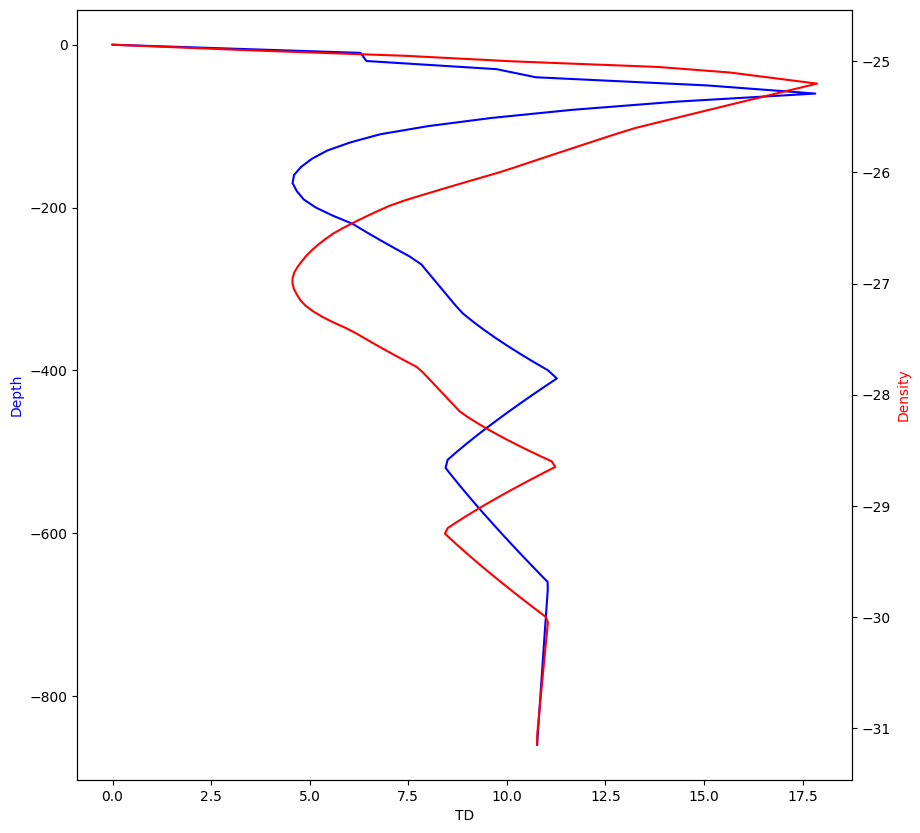

In [4]:
fig, ax1 = plt.subplots(figsize=(10, 10))
# Plot depth data
ax1.plot(depth_data['TD']/1000, depth_data['Depth'], 'b-')
ax1.set_xlabel('TD')
ax1.set_ylabel('Depth', color='b')

# Create a second y-axis for density data
ax2 = ax1.twinx()
ax2.plot(rho_data['TD']/1000, -rho_data['rho'], 'r-')
ax2.set_ylabel('Density', color='r')

plt.show()

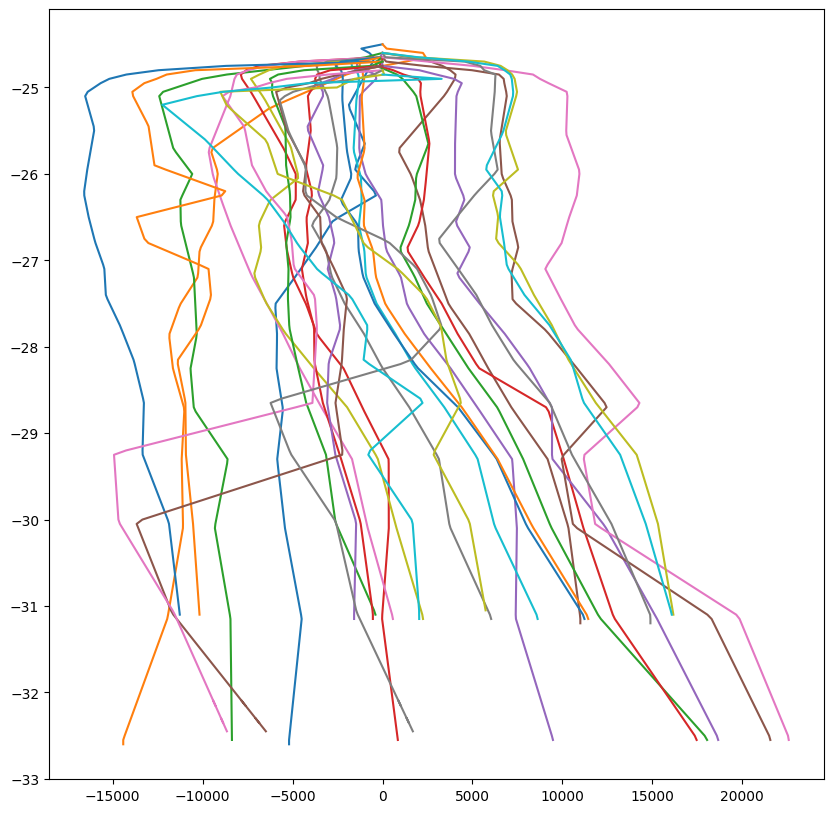

In [12]:
plt.figure(figsize=(10, 10))

medium = 'y'

dfs = []
for t in range(30):
    rho_data = sub_data['T'+str(t)]['rho_data'][['rho', medium]]

    rho_data.columns = ['rho', medium+str(t)]
    dfs.append(rho_data.set_index('rho'))  

combined_df = pd.concat(dfs, axis=1) 

for col in combined_df.columns:
    plt.plot(combined_df[col], -combined_df.index)


In [13]:
combined_df

,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y20,y21,y22,y23,y24,y25,y26,y27,y28,y29
rho,,,,,,,,,,,,,,,,,,,,,
24.50,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24.55,-1176.229254,228.432582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24.60,-733.831970,2248.329164,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24.65,-498.065381,2401.481005,-934.166620,0.000000,-133.141329,1590.176091,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24.70,-525.688557,1304.997319,-2527.407565,-4573.714165,-1419.674520,2670.792125,-4680.210293,-3066.735153,-2216.145198,-1733.605382,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-8010.151344,-9510.162486,778.777701,NaN,NaN
32.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-7438.653375,-9188.272985,1119.000868,NaN,NaN
32.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-7248.154052,-9080.976484,1232.408590,NaN,NaN


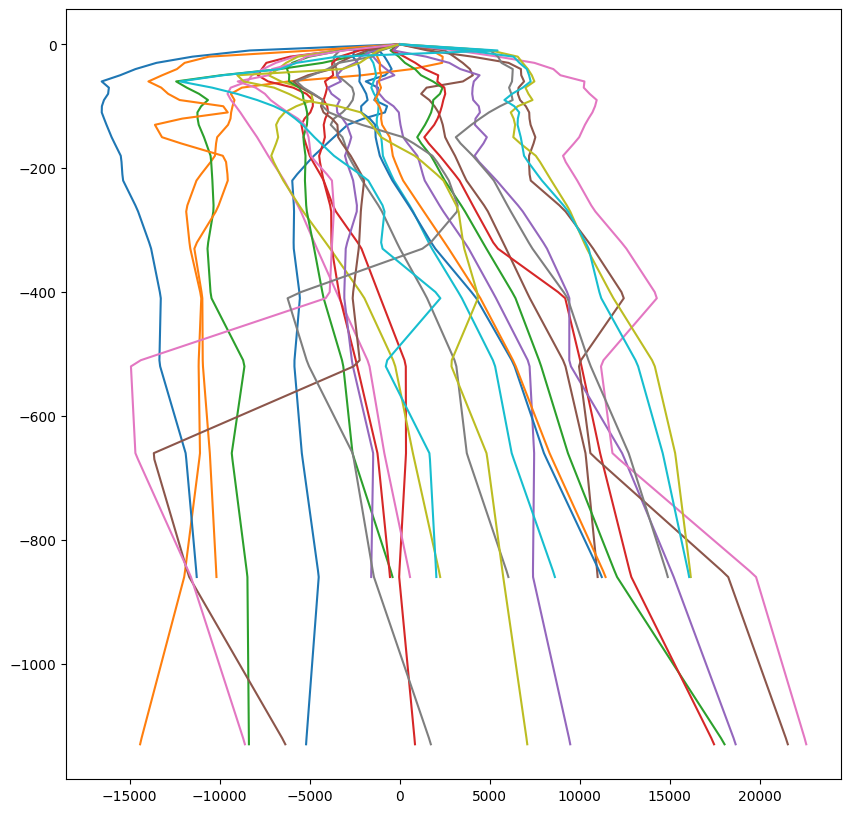

In [10]:
plt.figure(figsize=(10, 10))

medium = 'y'

dfs = []
for t in range(30):
    depth_data = sub_data['T'+str(t)]['depth_data'][['Depth', medium]]

    depth_data.columns = ['Depth', medium+str(t)]
    dfs.append(depth_data.set_index('Depth'))  # Set 'Depth' as index for clarity and to avoid confusion

combined_df = pd.concat(dfs, axis=1)  # Concatenate along columns

for col in combined_df.columns:
    plt.plot(combined_df[col], combined_df.index)


In [11]:
combined_df

,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y20,y21,y22,y23,y24,y25,y26,y27,y28,y29
Depth,,,,,,,,,,,,,,,,,,,,,
-0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-10.0,-1147.106706,1793.918321,-1201.174978,-3415.952647,-1385.409226,2511.894345,-3563.837732,-3323.274453,-3438.767533,-1838.455435,...,-8329.149971,-4857.126128,-3217.356222,-2226.803656,-1453.109639,-1796.921504,-3096.807120,-1031.828286,-1179.814150,5437.303260
-20.0,-838.864420,2389.914146,-2714.203714,-6086.939950,-1468.870871,3025.231848,-5848.666296,-3661.923448,-5654.184263,-1677.238678,...,-11511.228659,-10594.785119,-5027.943342,-3340.739561,-2178.257663,-2681.608455,-5195.659720,-1525.166512,-1701.359422,-3475.730639
-30.0,-627.882392,2361.786375,-4282.789988,-7405.430002,-1168.014234,3504.083436,-6879.256439,-3639.384644,-6307.957906,-1462.742471,...,-13508.784383,-11942.868486,-5967.613910,-3749.311304,-2469.531468,-3388.258471,-5762.147874,-3377.535367,-2217.138627,-5732.309272
-40.0,-445.046447,692.113857,-6657.658718,-7656.211196,-755.324273,3900.703785,-7581.555014,-3500.387637,-6751.633171,-1370.360563,...,-14670.109679,-12368.943350,-6253.246555,-3737.966350,-3176.469401,-3769.731679,-7083.671042,-4009.879570,-3162.580525,-6626.604329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-1090.0,-5094.988152,-14061.621869,-8383.962003,724.747584,9176.669795,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-7123.079612,-9029.060877,1275.305738,6895.621576,NaN
-1100.0,-5121.084827,-14152.669307,-8380.859104,757.378996,9253.462179,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-6924.623617,-8917.674442,1392.823984,6945.267651,NaN
-1110.0,-5147.181502,-14243.716745,-8377.756206,790.010408,9330.254564,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-6726.167623,-8806.288008,1510.342230,6994.913726,NaN
